In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

## Chl_ECS_his

In [2]:
input_folder = "../../Data/History/China_sea_chla/"

new_lon = np.linspace(117.34, 131.02, num=29)
new_lat = np.linspace(23.17, 32.80, num=21)

file_list = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.nc')]

ECS_CHL_his = []
for file_path in file_list:
    try:
        ds = xr.open_dataset(file_path)
        
        if 'longitude' not in ds or 'latitude' not in ds:
            print(f"Skipping file (no lon/lat): {file_path}")
            continue
        
        ds_ECS = ds.interp(longitude=new_lon, latitude=new_lat, method="linear")
        ds_ECS = ds_ECS.rename({'latitude': 'ny', 'longitude': 'nx'})
        ds_ECS = ds_ECS['CHL'].resample(time='1ME').mean()
        ds_ECS['time'] = pd.to_datetime(ds_ECS['time'].values).strftime('%Y-%m')
        ECS_CHL_his.append(ds_ECS)
   
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

ECS_CHL_his = xr.concat(ECS_CHL_his, dim='time').transpose('time', 'ny', 'nx').to_dataset()

# pre_extend to 1990 
data_1998 = ECS_CHL_his.sel(time=slice("1998-01", "1998-12"))
data_1990_1997 = xr.concat([data_1998] * 8, dim="time")
new_times = pd.date_range("1990-01-01", "1997-12-31", freq="ME").strftime('%Y-%m')
data_1990_1997 = data_1990_1997.assign_coords(time=("time", new_times))
ECS_CHL_his = xr.concat([data_1990_1997, ECS_CHL_his], dim="time")

ECS_CHL_his

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 360, ny: 21, nx: 29)
Coordinates:
  * nx       (nx) float64 232B 117.3 117.8 118.3 118.8 ... 130.0 130.5 131.0
  * ny       (ny) float64 168B 23.17 23.65 24.13 24.61 ... 31.84 32.32 32.8
  * time     (time) object 3kB '1990-01' '1990-02' ... '2019-11' '2019-12'
Data variables:
    CHL      (time, ny, nx) float64 2MB 0.6087 0.7257 0.6751 ... nan 2.994 nan

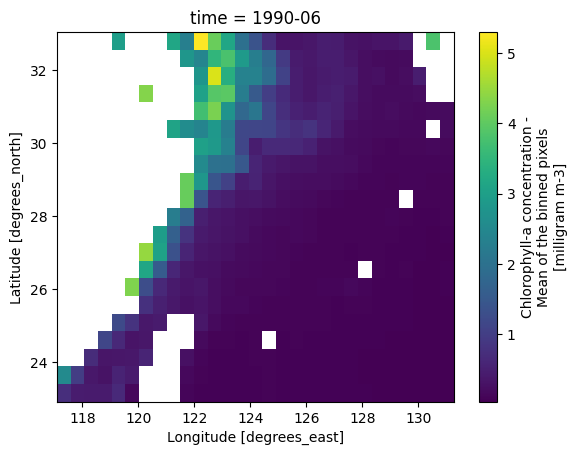

In [3]:
ECS_CHL_his.CHL.sel(time='1990-06').plot()

## Chl_ssp1_2020_2100

In [4]:
data_dir_list = ['../../Data/Future/Chla_2015-2099_ssp1-2.6/data/', '../../Data/Future/Chla_2015-2099_ssp2-4.5/data/', '../../Data/Future/Chla_2015-2099_ssp5-8.5/data/']
output_file_list = ['Chl-2015-2100_ssp1-2.6.nc', 'Chl-2015-2100_ssp2-4.5.nc', 'Chl-2015-2100_ssp5-8.5.nc']

for idx, data_dir in enumerate(data_dir_list):
    if idx == 0:
        nc_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.nc')])
        chl_ssp1 = []
        for nc_file in nc_files:
            ds = xr.open_dataset(nc_file)
            chl_ds = ds[['chl']].isel(i=slice(81, 110), j=slice(122, 143))  # ECS
            chl_ds = chl_ds.drop_vars(["latitude", "longitude"])
            chl_ds = chl_ds.rename({'j': 'ny', 'i': 'nx', 'chl': 'CHL'})
            chl_ds = chl_ds.isel(lev=slice(0, 2)).sum(dim='lev').squeeze()
            chl_ds = chl_ds.assign_coords(ny=("ny", np.linspace(23.17, 32.80, num=21)[::-1]), # flip lat
                                          nx=("nx", np.linspace(117.34, 131.02, num=29)))  
            chl_ds = chl_ds.sortby('ny')
            chl_ds['time'] = pd.to_datetime(chl_ds['time'].values).strftime('%Y-%m')
            chl_ds['CHL'] = chl_ds['CHL'].where(chl_ds['CHL'] != 0, np.nan)
            chl_ssp1.append(chl_ds.sel(time=slice("2020-01", "2100-12")))
            ds.close()  # release memory
        ssp_ECS_ds = xr.concat(chl_ssp1, dim='time').transpose('time', 'ny', 'nx')
        ssp_ECS_ds['CHL'] = ssp_ECS_ds['CHL'] * 1000000
        
ssp_ECS_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 972, ny: 21, nx: 29)
Coordinates:
  * time     (time) object 8kB '2020-01' '2020-02' ... '2100-11' '2100-12'
  * ny       (ny) float64 168B 23.17 23.65 24.13 24.61 ... 31.84 32.32 32.8
  * nx       (nx) float64 232B 117.3 117.8 118.3 118.8 ... 130.0 130.5 131.0
Data variables:
    CHL      (time, ny, nx) float32 2MB 0.7473 0.8286 1.251 ... 0.9577 1.144

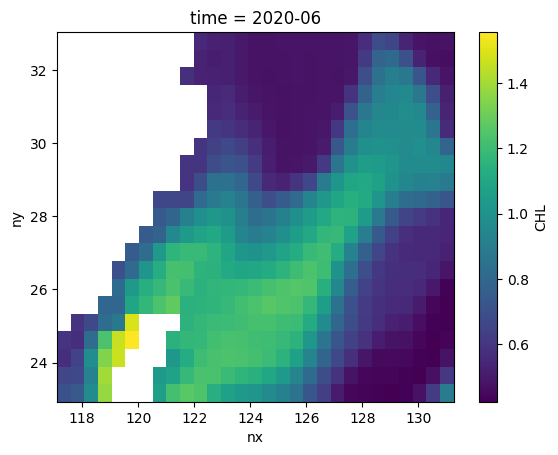

In [5]:
ssp_ECS_ds.sel(time='2020-06').CHL.plot()

In [6]:
ECS_CHL_ssp1_1990_2100 = xr.concat([ECS_CHL_his, ssp_ECS_ds], dim='time')
ECS_CHL_ssp1_1990_2100

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1332, ny: 21, nx: 29)
Coordinates:
  * nx       (nx) float64 232B 117.3 117.8 118.3 118.8 ... 130.0 130.5 131.0
  * ny       (ny) float64 168B 23.17 23.65 24.13 24.61 ... 31.84 32.32 32.8
  * time     (time) object 11kB '1990-01' '1990-02' ... '2100-11' '2100-12'
Data variables:
    CHL      (time, ny, nx) float64 6MB 0.6087 0.7257 0.6751 ... 0.9577 1.144

## ROK_CHL2Ltl

In [7]:
input_folder = "../../Data/History/ROK_sea_chla/"

new_lon = np.linspace(127, 129, num=10)
new_lat = np.linspace(34, 35, num=5)

file_list = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.nc')]

ROK_CHL_his = []
for file_path in file_list:
    try:
        ds = xr.open_dataset(file_path)
        
        if 'longitude' not in ds or 'latitude' not in ds:
            print(f"Skipping file (no lon/lat): {file_path}")
            continue
        
        ds_ROK = ds.interp(longitude=new_lon, latitude=new_lat, method="linear")
        ds_ROK = ds_ROK.rename({'latitude': 'ny', 'longitude': 'nx'})
        ROK_CHL_his.append(ds_ROK)
   
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

ROK_CHL_his = xr.concat(ROK_CHL_his, dim='time').transpose('time', 'ny', 'nx')
ROK_CHL_his = ROK_CHL_his.sel(time=slice("2002-01-01", "2005-12-31")).groupby("time.month").mean(dim="time")

ROK_CHL_his

<xarray.Dataset> Size: 5kB
Dimensions:  (month: 12, ny: 5, nx: 10)
Coordinates:
  * nx       (nx) float64 80B 127.0 127.2 127.4 127.7 ... 128.6 128.8 129.0
  * ny       (ny) float64 40B 34.0 34.25 34.5 34.75 35.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    CHL      (month, ny, nx) float64 5kB 0.6655 0.6623 0.6761 ... 2.462 1.21
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    subset:datasetId:  cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_...
    subset:date:       2024-12-01T05:37:58.178Z

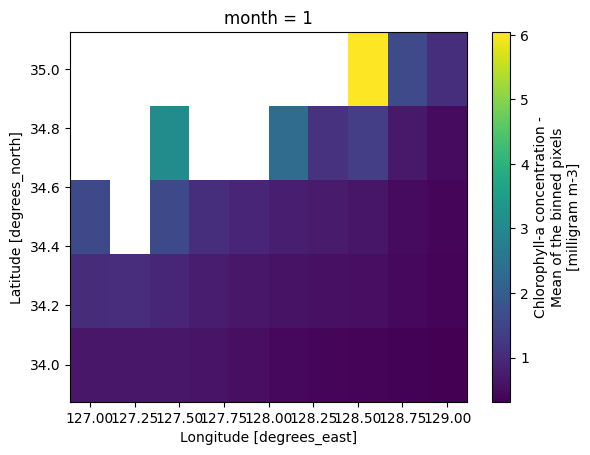

In [8]:
ROK_CHL_his.sel(month=1).CHL.plot()

In [9]:
## https://www.generic-mapping-tools.org/remote-datasets/earth-relief.html
ds = xr.open_dataset('../../Data/History/China_sea_bototm_dissolved_oxygen/earth_relief_06m_p.grd')

new_lon = np.linspace(117.34, 131.02, num=29)
new_lat = np.linspace(23.17, 32.80, num=21)

ds_ECS = ds.interp(lon=new_lon, lat=new_lat, method="linear")
ds_ECS = ds_ECS.rename({'lat': 'ny', 'lon': 'nx', 'z': 'depth'})
ds_ECS = ds_ECS.assign_coords(ny=("ny", new_lat), 
                              nx=("nx", new_lon))

ds_ECS 

<xarray.Dataset> Size: 5kB
Dimensions:  (ny: 21, nx: 29)
Coordinates:
  * ny       (ny) float64 168B 23.17 23.65 24.13 24.61 ... 31.84 32.32 32.8
  * nx       (nx) float64 232B 117.3 117.8 118.3 118.8 ... 130.0 130.5 131.0
Data variables:
    depth    (ny, nx) float64 5kB -36.57 -24.22 -21.35 ... 48.86 9.961 643.8
Attributes:
    Conventions:  CF-1.7
    GMT_version:  6.5.0 [64-bit] [MP]
    node_offset:  1
    title:        SRTM15 Earth Relief v2.6 at 06 arc minutes
    history:      
    description:  Reduced by Gaussian Cartesian filtering (31.5 km fullwidth)...

In [10]:
ROK_CHL_his_MA = ROK_CHL_his.mean(dim=["nx", "ny"])

ROK_Ltl = pd.read_csv("../../Data/ROK_Ltl_Biomass_Monthly.csv")
ROK_Ltl.insert(1, 'Chl', ROK_CHL_his_MA.CHL.values)
ROK_Ltl

,Month,Chl,SmallPhytoplankton,LargePhytoplankton,SmallZooplankton,LargeZooplankton,PredatoryZooplankton
0,Jan.,0.999594,33.464,17.622,2.377,7.448,12.047
1,Feb.,1.072847,31.316,15.152,2.273,6.119,11.027
2,Mar.,1.207124,34.807,13.534,2.711,5.873,11.590
3,Apr.,1.704343,23.564,9.825,2.635,4.277,9.860
4,May.,1.333953,21.126,11.527,2.463,4.564,9.518
5,Jun.,1.069120,20.971,13.387,2.228,5.113,10.023
6,Jul.,1.405498,33.315,20.972,2.205,7.830,11.981
7,Aug.,1.658184,45.864,17.883,2.713,7.180,12.748
8,Sep.,1.779198,32.463,10.912,2.873,5.076,10.408
9,Oct.,1.870466,30.497,9.960,3.095,5.031,9.553


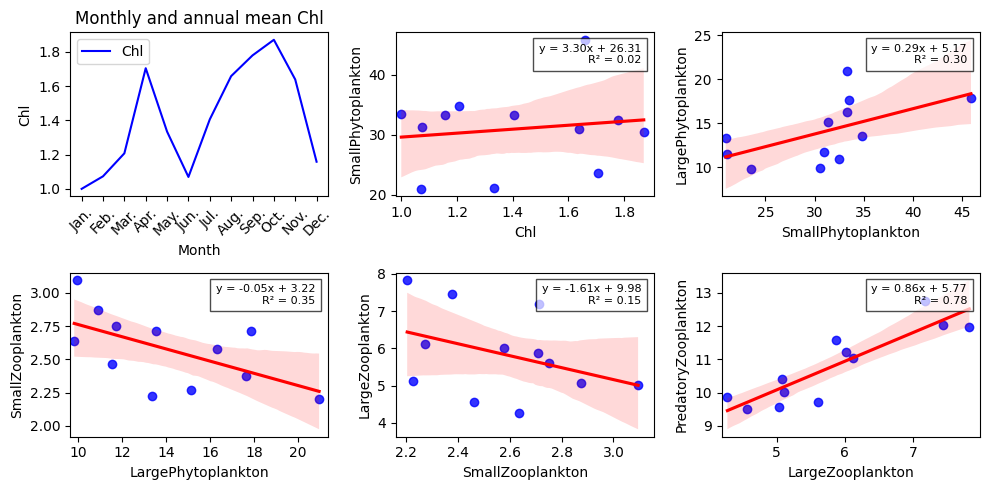

In [11]:
import seaborn as sns
from scipy.stats import linregress

fig, ax = plt.subplots(2, 3, figsize=(10, 5))

ax[0, 0].plot(ROK_Ltl['Month'], ROK_Ltl['Chl'], label="Chl", color='b')
ax[0, 0].set_title("Monthly and annual mean Chl")
ax[0, 0].set_xlabel("Month")
ax[0, 0].tick_params(axis='x', rotation=45)
ax[0, 0].set_ylabel("Chl")
ax[0, 0].legend()

Para_list = []
for i, Ltl_col in enumerate(ROK_Ltl.columns[2:], start=1):
    # slope, intercept, r_value, p_value, std_err = linregress(ROK_Ltl['Chl'], ROK_Ltl[Ltl_col])
    slope, intercept, r_value, p_value, std_err = linregress(ROK_Ltl.iloc[:, i], ROK_Ltl.iloc[:, i+1])
    Para_list.append((slope, intercept))
    sns.regplot(x=ROK_Ltl.iloc[:, i], y=ROK_Ltl.iloc[:, i+1], ax=ax[i//3, i%3], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    # ax[i//3, i%3].set_title(f"{ROK_Ltl.columns[i]} vs {Ltl_col}")
    ax[i//3, i%3].set_xlabel(f"{ROK_Ltl.columns[i]}")
    ax[i//3, i%3].set_xlim(0.98*ROK_Ltl.iloc[:, i].min(), 1.02*ROK_Ltl.iloc[:, i].max())
    ax[i//3, i%3].set_ylabel(Ltl_col)
    
    equation = f"y = {slope:.2f}x + {intercept:.2f}"
    r_squared = f"R² = {r_value**2:.2f}"
    ax[i//3, i%3].text(0.95, 0.93, f'{equation}\n{r_squared}', transform=ax[i//3, i%3].transAxes, fontsize=8,
                       va='top', ha='right', color='black', bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

In [12]:
ECS_CHL_ssp1_1990_2100

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1332, ny: 21, nx: 29)
Coordinates:
  * nx       (nx) float64 232B 117.3 117.8 118.3 118.8 ... 130.0 130.5 131.0
  * ny       (ny) float64 168B 23.17 23.65 24.13 24.61 ... 31.84 32.32 32.8
  * time     (time) object 11kB '1990-01' '1990-02' ... '2100-11' '2100-12'
Data variables:
    CHL      (time, ny, nx) float64 6MB 0.6087 0.7257 0.6751 ... 0.9577 1.144

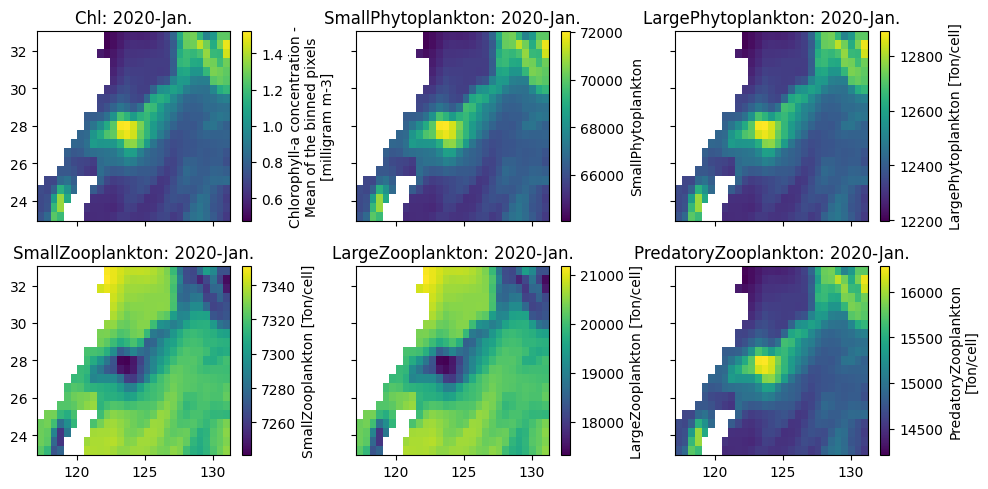

In [22]:
Ltl_names = ROK_Ltl.columns[2:]

Ltl_data = ECS_CHL_ssp1_1990_2100.copy()
# output_nc_file = "Chl_02_history.nc"

fig, ax = plt.subplots(2, 3, figsize=[10, 5], sharex=True, sharey=True)

for i in range(6):
    ECS_Ltl_ds_M = ECS_CHL_ssp1_1990_2100.copy()
    if i == 0:  
        ECS_CHL_ssp1_1990_2100.CHL.sel(time='2020-01').plot.pcolormesh(ax=ax[i//3, i%3])
        ax[i//3, i%3].set_title("Chl: 2020-Jan.")
    else:
        slope, intercept = Para_list[i-1][0], Para_list[i-1][1]
        ECS_Ltl_ds_M = (ECS_Ltl_ds_M * slope + intercept) * (1000 * 50000 ** 2 * np.abs(np.mean(ds_ECS["depth"])) / 1000000000000)
        if i == 1:
            ECS_Ltl_ds_M = ECS_Ltl_ds_M.rename({"CHL": Ltl_names[i-1]})
        else:
            ECS_Ltl_ds_M = ECS_Ltl_ds_M.rename({'CHL': Ltl_names[i-1]})
            ECS_Ltl_ds_M[Ltl_names[i-1]].attrs['units'] = 'Ton/cell'
        Ltl_data[Ltl_names[i-1]] = ECS_Ltl_ds_M[Ltl_names[i-1]]
        
        ECS_Ltl_ds_M[Ltl_names[i-1]].sel(time='2020-01').plot.pcolormesh(ax=ax[i//3, i%3])
        ax[i//3, i%3].set_title(Ltl_names[i-1]+": 2020-Jan.")
    ax[i//3, i%3].set_xlabel('')
    ax[i//3, i%3].set_ylabel('')

ECS_Ltl_nc = Ltl_data.drop_vars('CHL')
# ECS_Ltl_nc.to_netcdf(output_nc_file)
plt.tight_layout()
plt.show()

In [23]:
ECS_Ltl_nc

<xarray.Dataset> Size: 32MB
Dimensions:               (nx: 29, ny: 21, time: 1332)
Coordinates:
  * nx                    (nx) float64 232B 117.3 117.8 118.3 ... 130.5 131.0
  * ny                    (ny) float64 168B 23.17 23.65 24.13 ... 32.32 32.8
  * time                  (time) object 11kB '1990-01' '1990-02' ... '2100-12'
Data variables:
    SmallPhytoplankton    (time, ny, nx) float64 6MB 6.51e+04 ... 6.915e+04
    LargePhytoplankton    (time, ny, nx) float64 6MB 1.229e+04 ... 1.264e+04
    SmallZooplankton      (time, ny, nx) float64 6MB 7.337e+03 ... 7.281e+03
    LargeZooplankton      (time, ny, nx) float64 6MB 2.069e+04 ... 1.872e+04
    PredatoryZooplankton  (time, ny, nx) float64 6MB 1.447e+04 ... 1.553e+04

In [24]:
ECS_Ltl_nc.to_netcdf('ECS_physical.nc')

## 图

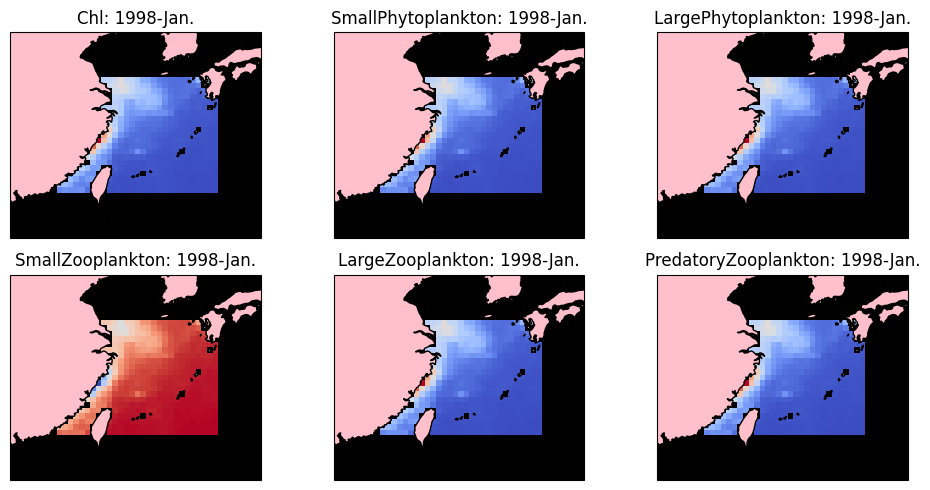

In [19]:
Ltl_names = ROK_Ltl.columns[2:]

Ltl_data = ECS_CHL_ssp1_1990_2100.copy()
output_nc_file = "ECS_physical.nc"

fig, ax = plt.subplots(2, 3, figsize=[10, 5], subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(6):
    ax[i//3, i%3].add_feature(cfeature.LAND, facecolor='pink', zorder=2)
    ax[i//3, i%3].add_feature(cfeature.OCEAN, facecolor='black', zorder=0)
    ax[i//3, i%3].coastlines(zorder=2)
    ax[i//3, i%3].set_extent([117-4, 131+4, 23-4, 33+4], crs=ccrs.PlateCarree())

    if i == 0:
        ECS_Ltl_ds_M = ECS_CHL_ssp1_1990_2100.copy()
        ECS_CHL_ssp1_1990_2100.CHL.sel(time='1990-01').plot.pcolormesh(ax=ax[i//3, i%3], transform=ccrs.PlateCarree(), x="nx",
                                                                y="ny", add_colorbar=False, cmap='coolwarm', zorder=1)
        ax[i//3, i%3].set_title("Chl: 1998-Jan.")
    else:
        slope, intercept = Para_list[i-1][0], Para_list[i-1][1]
        ECS_Ltl_ds_M = (ECS_Ltl_ds_M * slope + intercept) * (1000 * 50000 ** 2 * np.abs(np.mean(ds_ECS["depth"])) / 1000000000000)
        if i == 1:
            ECS_Ltl_ds_M = ECS_Ltl_ds_M.rename({"CHL": Ltl_names[i-1]})
        else:
            ECS_Ltl_ds_M = ECS_Ltl_ds_M.rename({Ltl_names[i-2]: Ltl_names[i-1]})
        Ltl_data[Ltl_names[i-1]] = ECS_Ltl_ds_M[Ltl_names[i-1]]
        
        ECS_Ltl_ds_M[Ltl_names[i-1]].sel(time='1990-01').plot.pcolormesh(ax=ax[i//3, i%3], transform=ccrs.PlateCarree(), x="nx",
                                                                  y="ny", add_colorbar=False, cmap='coolwarm', zorder=1)
        ax[i//3, i%3].set_title(Ltl_names[i-1]+": 1998-Jan.")

ECS_Ltl_nc = Ltl_data.drop_vars('CHL')
ECS_Ltl_nc.to_netcdf(output_nc_file)
plt.tight_layout()
plt.show()